In [1]:
from pyexpat import features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aiohttp.web_routedef import static
from mpmath import residual

df = pd.read_csv("/Users/lorenzoreinoso/Documents/MIT-StreetCar-Delay/data_updated.csv")

In [2]:
df.head(10)

,Date,Week,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2024-01-01,1,505,02:45,Monday,DUNDAS AND MCCAUL,Security,10,20,W,4416
1,2024-01-01,1,505,03:06,Monday,COLLEGE AND GLADSTONE,Emergency Services,52,72,E,4461
2,2024-01-01,1,503,03:21,Monday,PARLIAMENT AND SHUTTER,Security,0,0,N,4545
3,2024-01-01,1,505,03:53,Monday,DUNDAS WEST STATION,Security,37,0,W,4551
4,2024-01-01,1,600,04:27,Monday,QUEEN AND BATHURST,Diversion,78,93,E,8116
5,2024-01-01,1,501,04:33,Monday,QUEEN AND BATHRUST,Diversion,74,84,E,3531
6,2024-01-01,1,501,04:39,Monday,QUEEN AND PORTLAND,Diversion,39,49,W,4516
7,2024-01-01,1,507,04:52,Monday,RONCESVALLES YARD,General Delay,6,18,E,4479
8,2024-01-01,1,506,04:53,Monday,RONCESVALLE YARD,General Delay,13,28,E,4408
9,2024-01-01,1,501,04:54,Monday,RONCESVALLES YARD,General Delay,15,30,W,4411


In [3]:
df.shape

(11087, 11)

In [4]:
df = df[df["Min Delay"]>=15]
df.shape

(2459, 11)

In [5]:
df.head()

,Date,Week,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
1,2024-01-01,1,505,03:06,Monday,COLLEGE AND GLADSTONE,Emergency Services,52,72,E,4461
3,2024-01-01,1,505,03:53,Monday,DUNDAS WEST STATION,Security,37,0,W,4551
4,2024-01-01,1,600,04:27,Monday,QUEEN AND BATHURST,Diversion,78,93,E,8116
5,2024-01-01,1,501,04:33,Monday,QUEEN AND BATHRUST,Diversion,74,84,E,3531
6,2024-01-01,1,501,04:39,Monday,QUEEN AND PORTLAND,Diversion,39,49,W,4516


We want to make sure that we are taking into consideration all the events that had delay in order to predict, the time that it will take for them to arrive.

It's really important to take into consideration as much valuable information as we can.

In [6]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Date,object,273,"['2024-01-01', '2024-01-02', '2024-01-03'] ... (273 unique values)",0,0.000000
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,object,23,"['505', '600', '501'] ... (24 unique values)",4,0.160000
Time,object,1174,"['03:06', '03:53', '04:27'] ... (1174 unique values)",0,0.000000
Day,object,7,"['Monday', 'Tuesday', 'Wednesday'] ... (7 unique values)",0,0.000000
Location,object,794,"['COLLEGE AND GLADSTONE', 'DUNDAS WEST STATION', 'QUEEN AND BATHURST'] ... (794 unique values)",0,0.000000
Incident,object,13,"['Emergency Services', 'Security', 'Diversion'] ... (13 unique values)",0,0.000000
Min Delay,int64,182,"[52, 37, 78] ... (182 unique values)",0,0.000000
Min Gap,int64,194,"[72, 0, 93] ... (194 unique values)",0,0.000000
Bound,object,6,"['E', 'W', 'S'] ... (7 unique values)",329,13.380000



Shape of the DF (rows, columns): (2459, 11)
Rows: 2459
Columns: 11


With this analysis we can notice that we have some NAN values, in two columns Line and bound, they add up to 11% of our data set

Also with this table we can notice that there might be an "id" value, as the column with more Unique values is Vehicle, and can be Interpreted as something as a "car plate".

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2459 entries, 1 to 11072
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       2459 non-null   object
 1   Week       2459 non-null   int64 
 2   Line       2455 non-null   object
 3   Time       2459 non-null   object
 4   Day        2459 non-null   object
 5   Location   2459 non-null   object
 6   Incident   2459 non-null   object
 7   Min Delay  2459 non-null   int64 
 8   Min Gap    2459 non-null   int64 
 9   Bound      2130 non-null   object
 10  Vehicle    2459 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 230.5+ KB


With this approach we can see the data type of each of our columns most of them are categorical

In [8]:
# Lets work on our missing values

# Line has 16 registers with empty values, as it represents less than 1% of our data set it won't harm dropping them
df = df.dropna(subset=['Line'])
# Location has one empty value, lets drop it
df = df.dropna(subset=['Location'])

In [9]:
df["Bound"].value_counts()

Bound
E    879
W    780
N    238
S    228
B      1
8      1
Name: count, dtype: int64

In [10]:
# looking into the possible of our data in Bound, we can see the Cardinal point, and some "weird" values, also we have 1071 empty values representing 11.61% of our data set, if we get rid of them we are losing a los of info, that's why we are creating the category "other"
df['Bound'] = df['Bound'].replace(['B', '8', np.nan], 'Other')
df["Bound"].value_counts()

Bound
E        879
W        780
Other    330
N        238
S        228
Name: count, dtype: int64

Some the key aspects are now we dont have missing values, and we kept, as much information as possible.

In [11]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")


,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Date,object,273,"['2024-01-01', '2024-01-02', '2024-01-03'] ... (273 unique values)",0,0.000000
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,object,23,"['505', '600', '501'] ... (23 unique values)",0,0.000000
Time,object,1173,"['03:06', '03:53', '04:27'] ... (1173 unique values)",0,0.000000
Day,object,7,"['Monday', 'Tuesday', 'Wednesday'] ... (7 unique values)",0,0.000000
Location,object,793,"['COLLEGE AND GLADSTONE', 'DUNDAS WEST STATION', 'QUEEN AND BATHURST'] ... (793 unique values)",0,0.000000
Incident,object,13,"['Emergency Services', 'Security', 'Diversion'] ... (13 unique values)",0,0.000000
Min Delay,int64,182,"[52, 37, 78] ... (182 unique values)",0,0.000000
Min Gap,int64,194,"[72, 0, 93] ... (194 unique values)",0,0.000000
Bound,object,5,"['E', 'W', 'S'] ... (5 unique values)",0,0.000000



Shape of the DF (rows, columns): (2455, 11)
Rows: 2455
Columns: 11


We removed 17 values from the original data set, and joined some categorical features for the moment.

In [12]:
# Let's clean and prepare the information

# time is a categorical feature, but it can be represented on a scale from 0-1440 (0-24 hours in minutes)
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour * 60 + pd.to_datetime(df['Time'], format='%H:%M').dt.minute

In [13]:
# Let's make the date "more understandable"
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop("Date", axis=1, inplace=True) # as we extracted what we needed we can get rid of this column

In [14]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,object,23,"['505', '600', '501'] ... (23 unique values)",0,0.000000
Time,int32,1173,"[186, 233, 267] ... (1173 unique values)",0,0.000000
Day,int32,31,"[1, 2, 3] ... (31 unique values)",0,0.000000
Location,object,793,"['COLLEGE AND GLADSTONE', 'DUNDAS WEST STATION', 'QUEEN AND BATHURST'] ... (793 unique values)",0,0.000000
Incident,object,13,"['Emergency Services', 'Security', 'Diversion'] ... (13 unique values)",0,0.000000
Min Delay,int64,182,"[52, 37, 78] ... (182 unique values)",0,0.000000
Min Gap,int64,194,"[72, 0, 93] ... (194 unique values)",0,0.000000
Bound,object,5,"['E', 'W', 'S'] ... (5 unique values)",0,0.000000
Vehicle,int64,418,"[4461, 4551, 8116] ... (418 unique values)",0,0.000000



Shape of the DF (rows, columns): (2455, 12)
Rows: 2455
Columns: 12


In [15]:
# As year is a "constant" we can drop it
df.drop("Year", axis=1, inplace=True)

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Week,2455.0,20.279837,11.519141,1.0,10.0,20.0,31.0,40.0
Time,2455.0,742.964969,424.935427,0.0,341.0,778.0,1103.0,1439.0
Day,2455.0,15.505906,8.816375,1.0,8.0,15.0,23.0,31.0
Min Delay,2455.0,45.578819,59.109545,15.0,20.0,30.0,48.0,873.0
Min Gap,2455.0,55.787373,59.781131,0.0,30.0,40.0,60.0,883.0
Vehicle,2455.0,4643.459470,1383.710092,0.0,4452.0,4515.0,4575.0,8872.0
Month,2455.0,5.062322,2.625456,1.0,3.0,5.0,7.0,9.0


Our numerical data can be described and understood in this table something to be careful if the difference between the mean and the max value

It is very untypical in Min Gap and in Min Delay.

Also Vehicle is a categorical feature so it will be used that way

<Axes: ylabel='Min Delay'>

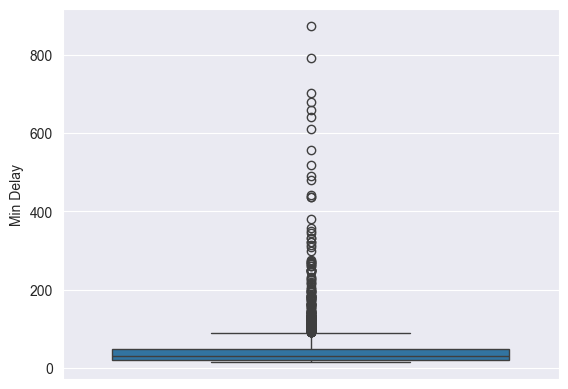

In [17]:
sns.boxplot(data = df, y = "Min Delay")

Our variable to ve predicted is the Min Delay, so we need to "remove" the outiers in order to have a more accurate model

/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_15371/2320036977.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


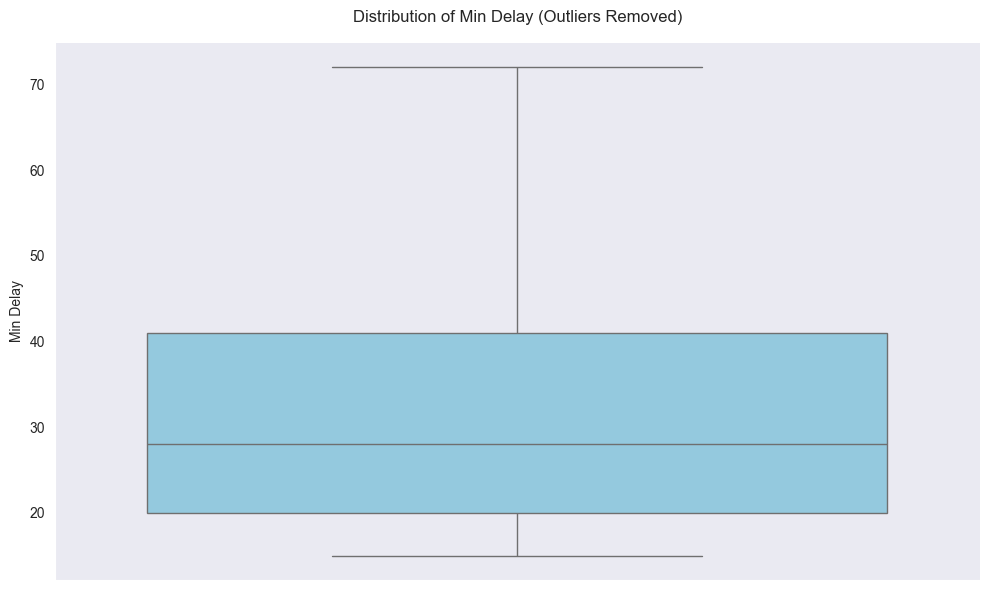

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers
df_clean = remove_outliers_iqr(df, 'Min Delay')

# Create a cleaner visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, y='Min Delay', color='skyblue', showfliers=False)

# Customize the plot
plt.title('Distribution of Min Delay (Outliers Removed)', pad=15)
plt.ylabel('Min Delay')

# Clean up the plot
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Use a clean background style
plt.style.use('seaborn-darkgrid')

plt.tight_layout()
plt.show()

In [19]:
df= df_clean

In [20]:
df.columns

Index(['Week', 'Line', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle', 'Month'], dtype='object')

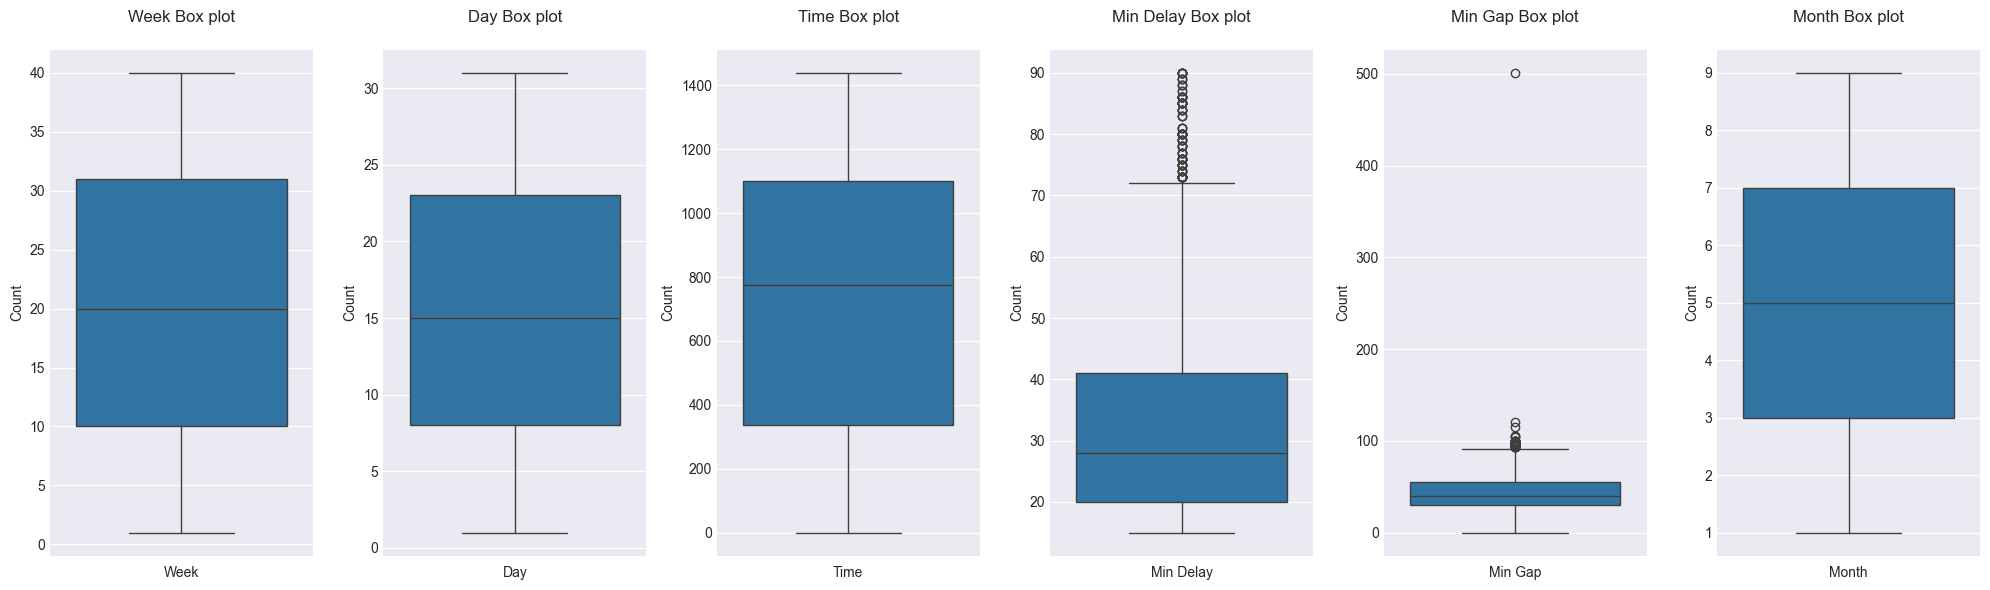

In [21]:
graficar_num = ['Week', 'Day', 'Time', 'Min Delay', 'Min Gap', 'Month']
plt.figure(figsize=(20, 6))

for idx, feature in enumerate(graficar_num, 1):
    plt.subplot(1, 6, idx)
    sns.boxplot(data=df, y=feature)
    plt.title(f'{feature} Box plot', pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

 as we look at the graphs above there is some work to do, the Min Delay and Min Gap Box plot show a lot of outliers

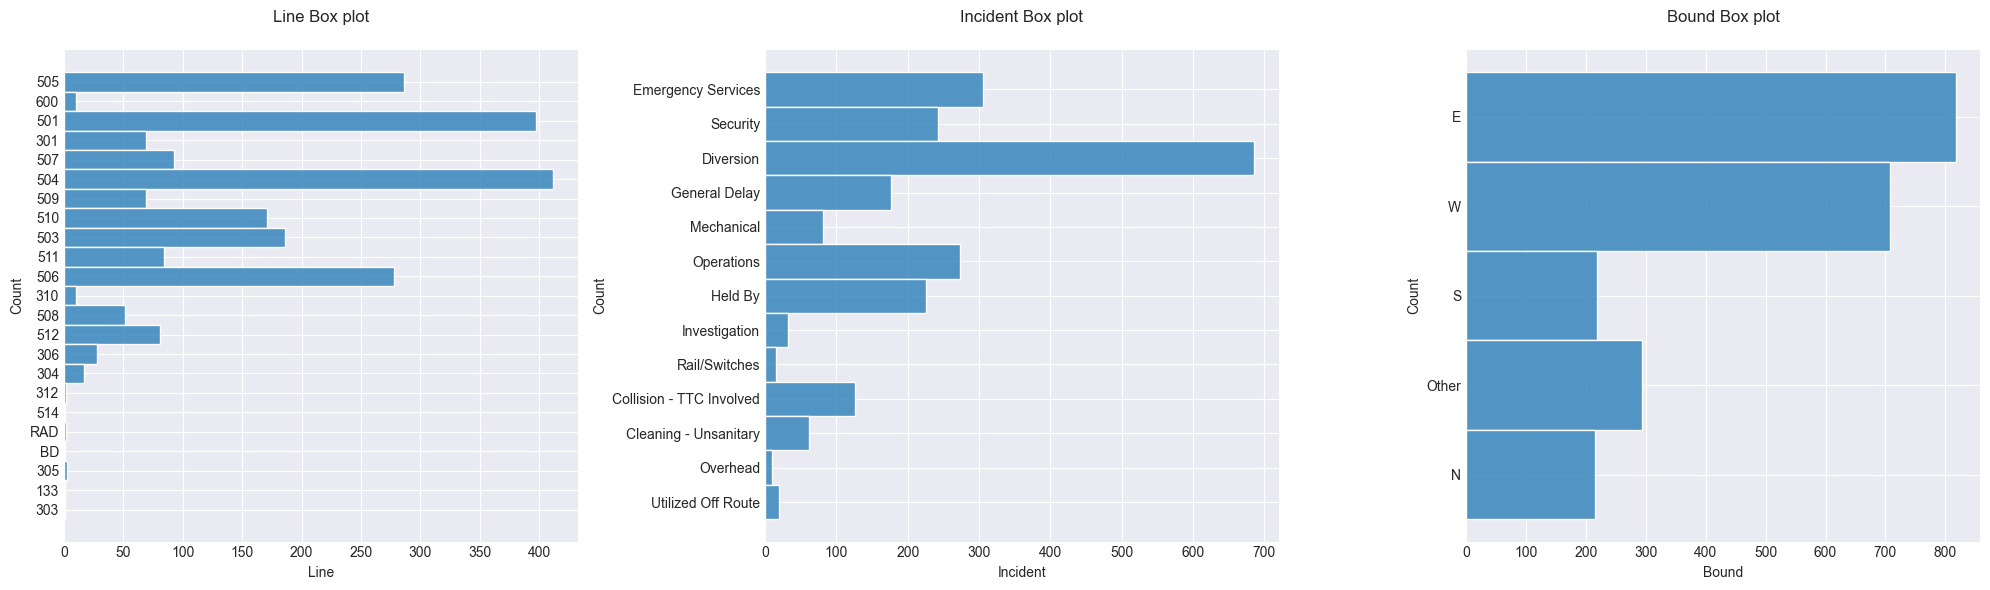

In [22]:
# Now let's analyze Categorical Features

cat = ['Line', 'Incident','Bound']
plt.figure(figsize=(20, 6))

for idx, feature in enumerate(cat, 1):
    plt.subplot(1, 3, idx)
    sns.histplot(data=df, y=feature)
    plt.title(f'{feature} Box plot', pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


When we select those columns with less than 100 "unique" values we can see that the is an interesting concentration of values on specific lines, an even in the incident causes, also the direction has values that "concentrate" in certain areas

In [23]:
df[("Vehicle")].value_counts()

Vehicle
0       73
4531    19
4423    19
4488    18
4431    18
        ..
8629     1
7044     1
8219     1
8082     1
8334     1
Name: count, Length: 397, dtype: int64

In [24]:
df[("Location")].value_counts()

Location
DUNDAS WEST STATION      50
BROADVIEW STATION        42
SPADINA STATION          35
LONG BRANCH LOOP         27
QUEEN AND BROADVIEW      25
                         ..
QUEEN AND WOODFIELD       1
QUEEN AND CONNAUGHT       1
LAKESHORE AND 28TH        1
CHERRY ST AND EASTERN     1
DUNDAS AND GEORGE         1
Name: count, Length: 751, dtype: int64

In [25]:
from sklearn.preprocessing import LabelEncoder
def preprocess_data(df):
    # Create copy to avoid modifying original data
    df_processed = df.copy()

    # Handle categorical variables more effectively
    le = LabelEncoder()
    categorical_cols = ['Line', 'Incident', 'Bound']
    for col in categorical_cols:
        df_processed[col] = le.fit_transform(df_processed[col])

    # Create frequency encoding for high cardinality features
    for col in ['Location', 'Vehicle']:
        freq_map = df_processed[col].value_counts(normalize=True).to_dict()
        df_processed[f'{col}_freq'] = df_processed[col].map(freq_map)
        df_processed.drop(col, axis=1, inplace=True)

    return df_processed
df = preprocess_data(df)


The values of location and Vehicle are specific, that why we have a lot of unique values, it is important to notice that there are some missing values in vehicle represented by "0", one solution could be getting random values and using them but for the moment we are leaving them as they are.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


X = df.drop('Min Delay', axis=1)
y = df['Min Delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, train_size=0.7)
X.head()

,Week,Line,Time,Day,Incident,Min Gap,Bound,Month,Location_freq,Vehicle_freq
1,1,11,186,1,3,72,0,1,0.000888,0.006214
3,1,11,233,1,11,0,4,1,0.022193,0.003107
4,1,20,267,1,2,93,0,1,0.005770,0.000444
5,1,8,273,1,2,84,0,1,0.000444,0.000444
6,1,8,279,1,2,49,4,1,0.001775,0.003995


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def train_random_forest(X_train, X_test, y_train, y_test):
    # Define parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize base model
    rf_model = RandomForestRegressor(random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    return best_model, grid_search.best_params_
best_model, best_params = train_random_forest(X_train_scaled, X_test_scaled, y_train, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [29]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return metrics, feature_importance
metrics, feature_importance = evaluate_model(
        best_model, X_train_scaled, X_test_scaled, y_train, y_test
    )

In [30]:
df.columns

Index(['Week', 'Line', 'Time', 'Day', 'Incident', 'Min Delay', 'Min Gap', 'Bound', 'Month', 'Location_freq', 'Vehicle_freq'], dtype='object')

In [41]:
new_case = pd.DataFrame({
    'Week': 21,
    'Line': 13,
    'Time': 224,
    'Day': 11,
    'Incident': 4,
    'Min Gap': 33,
    'Bound': 3,
    'Month': 8,
    'Location_freq': 0.000444,
    'Vehicle_freq': 0.003995
}, index=[0])  # Adding index=[0] ensures proper DataFrame format
21,0.080977567,0.008659571,7,2,4,3458,0,2024,5,24,14,4,0,0,0,0,1

prediction = best_model.predict(new_case)
prediction

array([67.48490476])

In [32]:
metrics

{'Train R2': 0.9801349983099054,
 'Test R2': 0.924841609258553,
 'Train RMSE': 2.469804547419817,
 'Test RMSE': 4.77396464549848,
 'Train MAE': 1.2702674911093406,
 'Test MAE': 2.5623497287763195}

In [33]:
feature_importance

,feature,importance
5,Min Gap,0.927176
2,Time,0.028574
1,Line,0.008567
3,Day,0.007402
9,Vehicle_freq,0.006747
4,Incident,0.006627
0,Week,0.005012
8,Location_freq,0.004792
6,Bound,0.003122
7,Month,0.001981


In [34]:
#Calcular residuos
residuals = y_test-best_model.predict(X_test_scaled)
residuals = residuals.values
residuals

array([-3.98956349e-01, -3.63371032e-01, -4.80815476e-01, -3.14773810e-01,
       -6.75695346e-01,  9.99376804e-01,  1.73562049e-01, -1.74688790e+01,
       -6.96761905e-01, -3.75813853e-01,  5.18274459e+00, -4.30833333e-02,
       -1.98087103e+00, -1.57083333e-01, -1.46760714e+00, -5.84875000e-01,
        8.00147096e+00,  1.94968651e+00, -8.50000000e-02, -7.40404762e-01,
       -3.40617460e+00, -1.13885119e+00, -8.46825397e-01,  1.08883149e+00,
        4.26033730e-01,  1.77500000e-02, -4.93976190e-01, -1.07093254e-01,
       -2.74438492e-01,  9.90952381e-02, -7.58055556e-02,  1.20664167e+01,
        1.05248214e+00, -3.33333333e-03, -3.10369048e-01, -9.76469246e+00,
        6.65494589e-01, -7.76910714e-01,  2.27003211e+00, -1.92524405e+00,
       -4.14208333e-01,  5.89705952e+00, -2.18579919e+00, -5.85238095e-02,
       -1.84581548e+00, -1.12949405e+00,  5.74674603e-01,  1.19920298e+01,
        1.37746032e-01,  2.16819444e+00,  2.17142857e-02, -1.83445635e+00,
        8.28460317e-01, -

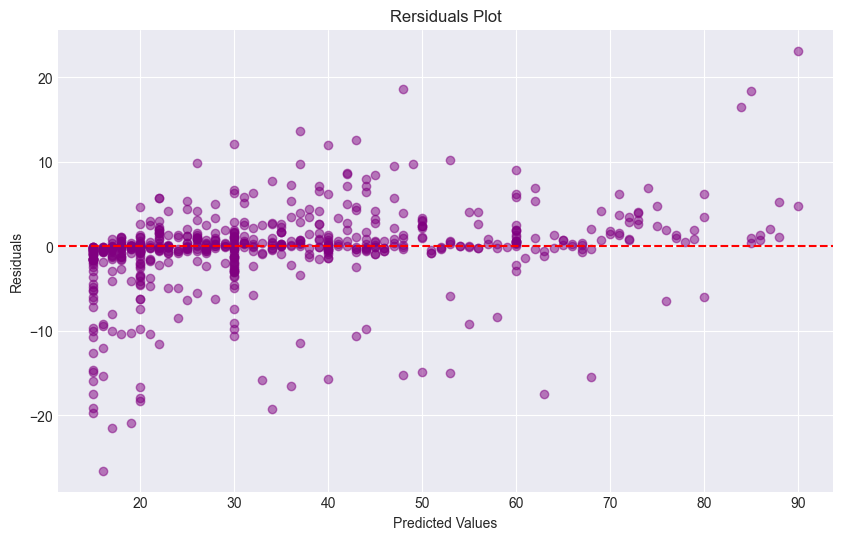

In [35]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red',linestyle='--')
plt.title('Rersiduals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

<Axes: xlabel='residuals', ylabel='Density'>

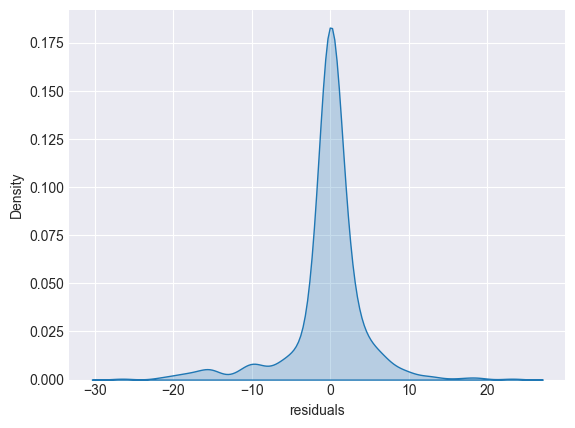

In [36]:
residuals = residuals.reshape(1,-1)
residuals = residuals[0]
res_df = pd.DataFrame({'residuals':residuals})
sns.kdeplot(res_df, x='residuals',fill=True)

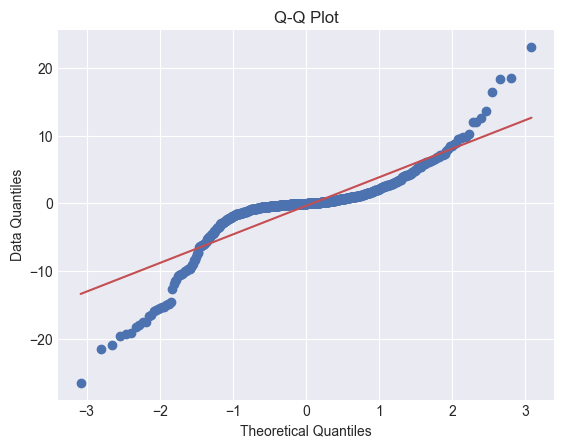

In [37]:
(osm,osr),(slope,intercept,r) = stats.probplot(residuals, dist='norm', plot=plt)
sns.set(style='whitegrid')
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Data Quantiles')
plt.show()

In [38]:
statistic, p_value = stats.shapiro(residuals)

print(f"Estadistico:{statistic}")
print(f"Valor P:{p_value}")

alpha = 0.05

if p_value <alpha:
  print("Rechazamos la hipotesis nula: los datos no siguen una distribucion normal")
else:
  print("Fallamos en rechazar la hipotesis nula. Los datos podrian seguir una distribucion normal")

Estadistico:0.7857183218002319
Valor P:7.421866550572055e-29
Rechazamos la hipotesis nula: los datos no siguen una distribucion normal
